In [28]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn
import tweepy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from secrets import CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_SECRET

seaborn.set()

In [2]:
NEWS_ORGS = {
    "BBC": "@BBC",
    "CBS": "@CBS",
    "FOX": "@FoxNews",
    "NYT": "@nytimes",
}

In [3]:
def get_api(consumer_key, consumer_secret, access_token, access_secret):
    """Returns a handle on the Twitter API, provided by Tweepy"""
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    return tweepy.API(auth)

In [6]:
api = get_api(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_SECRET)

In [9]:
def get_recent_tweets(api, orgs, count=100):
    """Downloads the 'count' most recent tweets from each org.

    api: twitter API handle, provided by Tweepy
    orgs: dictionary of {org name: twitter handle}
    count: number of tweets per org to get
    Returns a dictionary of {org name: [statuses...]}
    """
    results = {}
    for org, handle in orgs.items():
        most_recent_statuses = api.user_timeline(handle, count=100)
        results[org] = most_recent_statuses
    return results

In [10]:
recents = get_recent_tweets(api, NEWS_ORGS)

In [18]:
dir(recents["BBC"][0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_api',
 '_json',
 'author',
 'contributors',
 'coordinates',
 'created_at',
 'destroy',
 'entities',
 'extended_entities',
 'favorite',
 'favorite_count',
 'favorited',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'parse',
 'parse_list',
 'place',
 'possibly_sensitive',
 'retweet',
 'retweet_count',
 'retweeted',
 'retweets',
 'source',
 'source_url',
 'text',
 'truncated',
 'user']

In [26]:
this_tweet = recents["BBC"][0]
print(type(this_tweet.created_at))
this_tweet.created_at.date()

<class 'datetime.datetime'>


datetime.date(2018, 4, 5)

In [21]:
def analyze_tweets(tweets):
    """Analyze polarity sentiments of tweets.
    tweets: a list of Tweepy Status objects.
    Returns: a list of VADER polarity scores of the form
             {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
    """
    texts = [tweet.text for tweet in tweets]
    analyzer = SentimentIntensityAnalyzer()
    return [analyzer.polarity_scores(text) for text in texts]

In [22]:
org_sentiments = {org: analyze_tweets(tweets) for (org, tweets) in recents.items()}
org_sentiments["BBC"][:5]

[{'compound': 0.7096, 'neg': 0.0, 'neu': 0.629, 'pos': 0.371},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': -0.765, 'neg': 0.32, 'neu': 0.68, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}]

In [27]:
df_data = []
for org, tweets in recents.items():
    for ind, tweet in enumerate(tweets):
        df_data.append([
            tweet.created_at.date(),
            org,
            tweet.text,
            org_sentiments[org][ind]["neg"],
            org_sentiments[org][ind]["neu"],
            org_sentiments[org][ind]["pos"],
            org_sentiments[org][ind]["compound"],
        ])
tweet_data = pd.DataFrame(df_data)
tweet_data.columns = ["date", "organization", "text", "neg", "neu", "pos", "compound"]
tweet_data.head()

,date,organization,text,neg,neu,pos,compound
0,2018-04-05,BBC,🐆 Could building walkways in nature help save ...,0.00,0.629,0.371,0.7096
1,2018-04-05,BBC,😋😋 Pocket-friendly recipes for two.\n👉 https:/...,0.00,1.000,0.000,0.0000
2,2018-04-05,BBC,"👀 From illegal ivory to taxidermy, take a peek...",0.32,0.680,0.000,-0.7650
3,2018-04-05,BBC,RT @bbccomedy: Smithy is an irl ray of #sunshi...,0.00,1.000,0.000,0.0000
4,2018-04-05,BBC,RT @BBCTheOneShow: ..@DIYSOS are building a g...,0.00,1.000,0.000,0.0000


In [52]:
print(tweet_data.shape)

(400, 7)


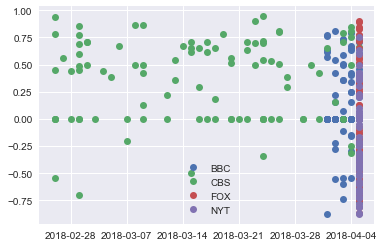

In [43]:
for org in NEWS_ORGS.keys():
    subset = tweet_data[tweet_data["organization"]==org]
    plt.plot(subset["date"], subset["compound"], 'o', label=org)
    
plt.legend()
plt.show()

In [53]:
tweet_data.to_csv("4-5-18-1344_tweet_data.csv")